In [13]:
%load_ext autoreload
%autoreload 2

from NLP_Lib import *

# import tensorflow as tf
from tensorflow import keras
import matplotlib as mpl
import matplotlib.pyplot as plt
from datetime import datetime
import pandas as pd
import math
import numpy as np
from numpy import dtype

import tensorflow_hub as hub
import tensorflow.compat.v1 as tf
# disable eager execution to use ELMo model
tf.disable_eager_execution()

# improve/change plot appearance
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# load in the training data, make sure it is the form we expect
training_df = pd.read_table(PATH_TO_TRAINING_DATA)
assert (training_df.shape[1] > 1 and CLASS_COL == training_df.columns[1]
    and training_df.shape[1] > 2 and SUBCLASS_COL == training_df.columns[2]
    and training_df.shape[1] > 3 and TEXT_COL == training_df.columns[3])

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
# *** Inspecting the data as it is at the beginning ***
training_df[CLASS_COL].unique()

array(['Bart Simpson', 'Homer Simpson', 'Marge Simpson', 'Other',
       'Lisa Simpson', nan], dtype=object)

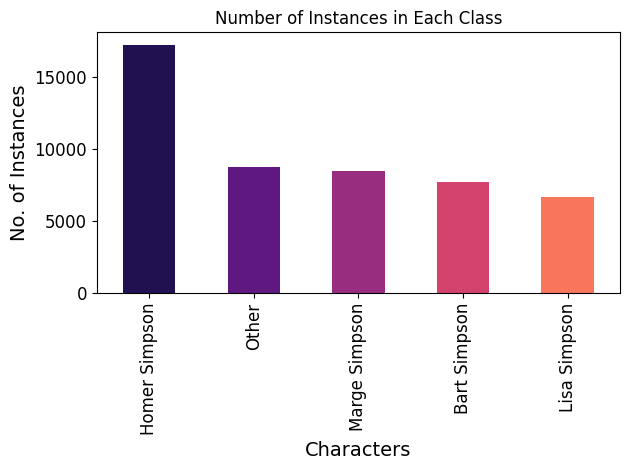

In [8]:
# looking at the number of instances per class, or label
make_and_save_inst_per_class_plot(
    training_df,
    plt,
    "Number of Instances in Each Class",
    CLASS_COL)

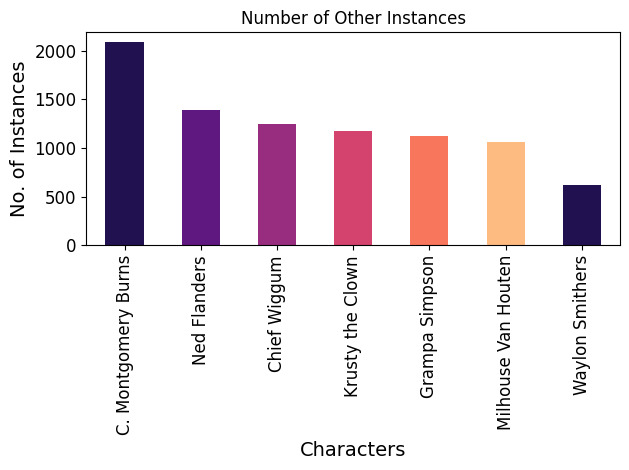

In [35]:
make_and_save_inst_per_class_plot(
    training_df[training_df[CLASS_COL] == "Other"],
    plt,
    "Number of Other Instances",
    SUBCLASS_COL)

In [3]:
# Cleaning and preprocessing the data

# Want to be able to do k-fold cross val eventually, so first shuffle the data
training_df = training_df.sample(frac=1).reset_index(drop=True)
training_df

,id,class,subclass,text
0,11910,Homer Simpson,Homer Simpson,"Yeah, get him a woman. That'll end his misery!"
1,24785,Marge Simpson,Marge Simpson,I'm sleeping on the couch.
2,11535,Lisa Simpson,Lisa Simpson,"Bart, if you don't get up now, good luck getti..."
3,16755,Marge Simpson,Marge Simpson,"Oh my, they made you a shrine!"
4,38366,Other,C. Montgomery Burns,"Why, you'd have to get up."
...,...,...,...,...
48929,22706,Marge Simpson,Marge Simpson,This house has such beautiful wainscoting.
48930,17186,Bart Simpson,Bart Simpson,"Hang on, Dad, this next part'll definitely mak..."
48931,41996,Homer Simpson,Homer Simpson,"This may surprise you, but you can't buy me of..."
48932,56740,Homer Simpson,Homer Simpson,That's okay. You don't have to make her into s...


In [ ]:
# Now lets define our NN, using ELMo as the first layer, the embedding layer
output_shape_size = 150
language_model_path = ELMO_HANDLE
activation_fnx = "tanh"
language_model = hub.Module(ELMO_HANDLE, trainable=True)

hub.KerasLayer(
    language_model_path,
    input_shape=(1,),
    output_shape=[output_shape_size]
    trainable=True
    dtype=tf.string,
)
hub.KerasLayer( # This layer is a word embedding layer
    language_model_path,
    input_shape=(1,),
    output_shape=[output_shape_size]
    trainable=True
    dtype=tf.string,
    #output_key="elmo",
    ),
model = keras.Sequential([
    keras.layers.Dense(128, activation=activation_fnx),
    keras.layers.Dense(5, activation='softmax'),
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(), # SGD, RMSprop, Adam, Adadelta, Adagrad, Adamax Nadam, Ftrl
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"])

model.summary()

# sharding settings for dev defined GPU work distribution
# (AutoShardPolicy.DATA or AutoShardPolicy.OFF)
options = tf.data.Options()
options.experimental_distribute.auto_shard_policy = tf.data.experimental.AutoShardPolicy.DATA

In [3]:
epochs = 150
batch_size = 128
Y = tf.convert_to_tensor(training_df[CLASS_COL].map(map_class_to_float))
# call back to save model at each epoch.
# For every training, a new dir will be made so as to not overwrite past weights
# This will make checkpoints ./model_checkpoints/some_time/save_at_epoch_num.h5
checkpoint_dir_x = os.path.join(CHECKPOINT_DIR, datetime.now().strftime("%m/%d/%Y, %H:%M:%S"))
pathlib.Path(checkpoint_dir_x).mkdir(parents=True, exist_ok=True)
callbacks = [
    keras.callbacks.ModelCheckpoint(os.path.join(checkpoint_dir_x, "save_at_{epoch}.h5")),
]

# start training!
history = model.fit(
    x=X,
    y=Y,
    validation_split=0.2,
    batch_size=batch_size,
    epochs=epochs,
    verbose=2, # 0 is silent, 1 for loading bar, 2 for stats each epoch
    callbacks=callbacks,
    shuffle=True)


plot_accuracy(plt, history, checkpoint_dir_x)
plot_loss(plt, history, checkpoint_dir_x)
# confusion_matrix(validation, model, plt, checkpoint_dir_x)

   

TypeError: map_str_to_padded_longest_str() missing 1 required positional argument: 'longest_str_ln'